In [20]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Carregar os dados com ajustes para evitar erros
ratings_df = pd.read_csv("../bookdataset/BX-Book-Ratings.csv", sep=";", encoding="latin-1", on_bad_lines='skip',  low_memory=False  )
books_df = pd.read_csv( "../bookdataset/BX-Books.csv", sep=";", encoding="latin-1", quotechar='"', on_bad_lines='skip', low_memory=False)
users_df = pd.read_csv("../bookdataset/BX-Users.csv", sep=";", encoding="latin-1", on_bad_lines='skip', low_memory=False)

In [21]:
# Contar usuários e livros antes da filtragem 
num_users_before = ratings_df['User-ID'].nunique()
num_books_before = ratings_df['ISBN'].nunique()

print(f"Número total de usuários antes da filtragem: {num_users_before}")
print(f"Número total de livros antes da filtragem: {num_books_before}")

# Filtrar usuários e livros com interações mínimas
user_id_counts = ratings_df['User-ID'].value_counts()
filtered_user_ids = user_id_counts[user_id_counts >= 250].index  # Considerar usuários que avaliaram pelo menos 250 livros
ratings_df = ratings_df[ratings_df['User-ID'].isin(filtered_user_ids)]

isbn_counts = ratings_df['ISBN'].value_counts()
filtered_isbn = isbn_counts[isbn_counts >= 50].index  # Considerar livros com pelo menos 50 avaliações
ratings_df = ratings_df[ratings_df['ISBN'].isin(filtered_isbn)]



Número total de usuários antes da filtragem: 105283
Número total de livros antes da filtragem: 340556



Usuários restantes após ajuste: 688
Livros restantes após ajuste: 415

 100 primeiros livros após filtragem:
['The Testament' 'Wild Animus' 'Airframe' 'Timeline'
 'To Kill a Mockingbird' 'Seabiscuit: An American Legend'
 "I'll Be Seeing You" 'Isle of Dogs' 'Purity in Death' 'The Street Lawyer']


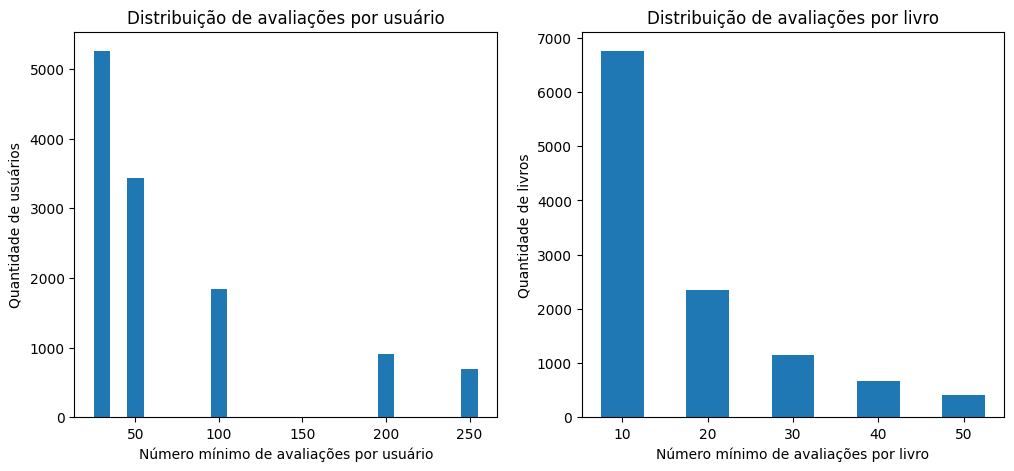

In [22]:
# Contar usuários e livros após a filtragem
num_users_after = ratings_df['User-ID'].nunique()
num_books_after = ratings_df['ISBN'].nunique()
print(f"\nUsuários restantes após ajuste: {num_users_after}")
print(f"Livros restantes após ajuste: {num_books_after}")

# Exibir os 100 primeiros livros pós-filtragem
print("\n 100 primeiros livros após filtragem:")
filtered_books = books_df[books_df["ISBN"].isin(ratings_df["ISBN"].unique())]["Book-Title"].unique()[:10]
print(filtered_books)

# Gerar gráficos para análise da distribuição das avaliações
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribuição de avaliações por usuário
bins_user = [30, 50, 100, 200, 250]
users_count = [sum(user_id_counts >= x) for x in bins_user]
axes[0].bar(bins_user, users_count, width=10)
axes[0].set_xlabel("Número mínimo de avaliações por usuário")
axes[0].set_ylabel("Quantidade de usuários")
axes[0].set_title("Distribuição de avaliações por usuário")

# Distribuição de avaliações por livro
bins_books = [10, 20, 30, 40, 50]
books_count = [sum(isbn_counts >= x) for x in bins_books]
axes[1].bar(bins_books, books_count, width=5)
axes[1].set_xlabel("Número mínimo de avaliações por livro")
axes[1].set_ylabel("Quantidade de livros")
axes[1].set_title("Distribuição de avaliações por livro")

plt.show()

In [23]:
# Mesclar as avaliações com os títulos dos livros
merged_df = pd.merge(ratings_df, books_df[['Book-Title', 'ISBN']], on='ISBN')

# Criar uma tabela pivot para representar a relação entre livros e usuários
pivot_table = merged_df.pivot_table(index='ISBN', columns='User-ID', values='Book-Rating').fillna(0)

# Função para recomendar livros similares usando KNN
def knn_recommendation(book_title, recommend_size=5):
    books = []
    
    # Encontrar o ISBN do livro a partir do título
    isbn = books_df.loc[books_df['Book-Title'] == book_title, 'ISBN'].values[0]
    
    # Treinar o modelo KNN com base na similaridade dos livros
    knn_model = NearestNeighbors(n_neighbors=recommend_size+1, metric='cosine').fit(pivot_table.values)
    
    # Encontrar os livros mais próximos com base na similaridade de coseno
    distances, indices = knn_model.kneighbors([pivot_table.loc[isbn].values], n_neighbors=recommend_size+1)
    
    # Armazenar os livros recomendados (excluindo o próprio livro consultado)
    for i in range(1, len(indices[0])):  # Começa em 1 para excluir o próprio livro
        books.append([pivot_table.index[indices[0][i]], 1 - distances[0][i]])  # 1 - distância para similaridade

    # Ordenar do mais similar para o menos similar
    books.sort(key=lambda x: x[1], reverse=True)

    return books  # Retorna uma lista de recomendações com ISBNs e similaridades




In [24]:
# Obter recomendações para um livro específico
book_title = "The Lost World"  # Título do livro para busca de similares
recommend_size = 5  # Quantidade de livros recomendados
knn_books = knn_recommendation(book_title, recommend_size)

# Exibir os livros recomendados com valores de similaridade mais intuitivos
print("\n Livros semelhantes a:", book_title)
for isbn, similarity in knn_books:
    book_title = books_df.loc[books_df['ISBN'] == isbn, 'Book-Title'].values[0]
    print(f"- {book_title} (Sim: {similarity:.2f})")


 Livros semelhantes a: The Lost World
- Jurassic Park (Sim: 0.33)
- The House of the Spirits (Sim: 0.30)
- Disclosure (Sim: 0.28)
- Like Water for Chocolate: A Novel in Monthly Installments With Recipes, Romances and Home Remedies (Sim: 0.26)
- The Celestine Prophecy (Celestine Prophecy) (Sim: 0.25)
